# Import

In [2]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
from cycler import cycler

In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib notebook

# Data structure

In [4]:
correlations = {'X' : {'direction': 'X'}, 'Y' : {'direction': 'Y'}, 'Z' : {'direction': 'Z'}}

# Read files

## Reading routines

In [5]:
def read_correlation_file(common_folder, folder_in, file_type, quantity, iterations, direction) :
    iterations_list = list(range(iterations[0], iterations[1], iterations[2]))
    nb_of_iterations = len(iterations_list)
    for i in iterations_list :
        file = common_folder + folder_in + file_type + "_for_" + quantity + "_at_" + "%06d" % i + "_dir_" + direction + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = 1.0/nb_of_iterations
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (i == iterations_list[0]) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    numpy_file_table = np.array(accumulated_data)
    return numpy_file_table

In [6]:
# def read_scalar_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
#     file = common_folder + forlder_in + "spectrum_" + quantity + "_" + spec_type + "_ite=%06d" % ite + ".table"
#     print('reading file: ' + file)
#     file_data = []
#     for line in open(file) :
#         temp_array_line = []
#         if line[0] == '#' :          #skip commented lines
#             continue
#         else :
#             temp_array_line=list(map(float, line.split( )))
#             file_data.append(temp_array_line)  
#     spec_table = np.array(file_data)
#     #k = spec_table[:,0]
#     #nb_of_modes = spec_table[:,1]
#     Es = spec_table[:,2]
#     return Es

In [7]:
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_spec_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
    Exx = spec_table[:,3]
    Eyy = spec_table[:,4]
    Ezz = spec_table[:,5]
    return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
# return [k, nb_of_modes, Ek]

In [8]:
def read_flow_stat(common_folder, forlder_in, simu) :
    file = common_folder + forlder_in + "Flow_stat.out"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            try :
                temp_array_line=list(map(float, line.split( )))
                file_data.append(temp_array_line)  
            except : 
                temp_array_line = ''        
    spec_table = np.array(file_data)[1::]
    simu.update({'time': spec_table[:,0], 'e_kine' : spec_table[:,1], 'lambda' : spec_table[:,2], 'Re_lambda' : spec_table[:,3], 'epsilon' : spec_table[:,4], \
                 'eta': spec_table[:,5], 'u^2' : spec_table[:,6], 'v^2' : spec_table[:,7], 'w^2' : spec_table[:,8], \
                 'du/dx^2' : spec_table[:,9], 'dv/dy^2' : spec_table[:,10], 'dw/dz^2' : spec_table[:,11], 'skewness_u' : spec_table[:,12], \
                 'flatness_u' : spec_table[:,13], 'skewness_deriv': spec_table[:,14], 'enstrophy' : spec_table[:,15], 'helicity' : spec_table[:,16]})
    return spec_table

In [9]:
def find_D0(prefactor, nu, eps, Sc, N, keta) :
    return [prefactor*4.0*nu*eps/Sc*((2.0*keta/N)**(-eps)), np.pi*N/keta]

## Path and parameters of the simulation

In [99]:
common_folder = "/home/gorbunov8a/CODE/random_advection_test/"
folder_in = "e43/"

eps_scaling = 4/3
D0 = 0.001

max_iter = 600

## Read velocity correlations in physical space

In [100]:
# Read velocity correlations in physical space
file_type = "twoPointCorr"
quantity = "velo"

#folder_in = "e43/keta10/correlations/"
iterations = [1, max_iter, 1]
for direction in {'X', 'Y', 'Z'} :
    table = read_correlation_file(common_folder, folder_in, file_type, quantity, iterations, direction)
    r = table[:,0]
    correlations[direction].update({'r' : table[:,0]})
    correlations[direction].update({'XX' : table[:,1]})
    correlations[direction].update({'YY' : table[:,2]})
    correlations[direction].update({'ZZ' : table[:,3]})
    correlations[direction].update({'XY' : table[:,4]})
    correlations[direction].update({'XZ' : table[:,5]})
    correlations[direction].update({'YZ' : table[:,6]})

reading file: /home/gorbunov8a/CODE/random_advection_test/e43/twoPointCorr_for_velo_at_000001_dir_Y.table


FileNotFoundError: [Errno 2] No such file or directory: '/home/gorbunov8a/CODE/random_advection_test/e43/twoPointCorr_for_velo_at_000001_dir_Y.table'

## Read scalar structure functions

In [101]:
# file_type = "structFonc02thOrder"
# quantity = "ScalarS1"

# #folder_in = "e43/keta10/correlations/"
# iterations = [10, max_iter, 10]
# for direction in {'X', 'Y', 'Z'} :
#     table = read_correlation_file(common_folder, folder_in, file_type, quantity, iterations, direction)
#     r = table[:,0]
#     correlations[direction].update({'S2_scal1' : table[:,1]})

# # quantity = "ScalarS2"
# # for direction in {'X', 'Y', 'Z'} :
# #     table = read_correlation_file(common_folder, folder_in, file_type, quantity, iterations, direction)
# #     r = table[:,0]
# #     correlations[direction].update({'S2_scal2' : table[:,1]})
    
# # quantity = "ScalarS3"
# # for direction in {'X', 'Y', 'Z'} :
# #     table = read_correlation_file(common_folder, folder_in, file_type, quantity, iterations, direction)
# #     r = table[:,0]
# #     correlations[direction].update({'S2_scal3' : table[:,1]})

## Read velocity spectrum

In [102]:
#folder_in = "e43/keta1/"
[k, nb_of_modes, Ek, Exx, Eyy, Ezz, Var, Varxx, Varyy, Varzz] = read_spec_file(common_folder, folder_in, "vel", "lin", max_iter)
#[k, nb_of_modes, Ek] = read_spec_file(common_folder, folder_in, "vel", "lin", 390)

reading file: /home/gorbunov8a/CODE/random_advection_test/e43/vel_spec_lin_ite=000600.table


In [103]:
# Read Flow stats 
read_flow_stat(common_folder, folder_in, correlations)

reading file: /home/gorbunov8a/CODE/random_advection_test/e43/Flow_stat.out


array([[ 6.544984e-04,  3.608890e+01,  3.894722e-01, ...,  1.815691e-03,
         1.361222e+03, -3.468416e+00],
       [ 1.308997e-03,  3.704835e+01,  3.888227e-01, ..., -3.472578e-03,
         1.357158e+03,  2.031447e+00],
       [ 1.963495e-03,  3.655036e+01,  3.907150e-01, ...,  4.106007e-03,
         1.357782e+03, -6.286016e+00],
       ...,
       [ 3.933536e-01,  3.787558e+01,  3.797627e-01, ..., -1.467449e-02,
         1.361814e+03, -8.580153e+00],
       [ 3.940081e-01,  3.603719e+01,  3.643080e-01, ..., -4.380641e-03,
         1.359050e+03, -6.263738e+00],
       [ 3.946626e-01,  3.892776e+01,  3.733884e-01, ...,  6.936750e-03,
         1.360957e+03, -7.968968e+00]])

## Read scalar spectra

In [47]:
# Es1 = read_scalar_spec_file(common_folder, folder_in, "scalar1", "lin", max_iter)
# # Es2 = read_scalar_spec_file(common_folder, folder_in, "scalar2", "lin", max_iter)
# # Es3 = read_scalar_spec_file(common_folder, folder_in, "scalar3", "lin", max_iter)

# Plot options

In [95]:
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

# Time stats

<IPython.core.display.Javascript object>


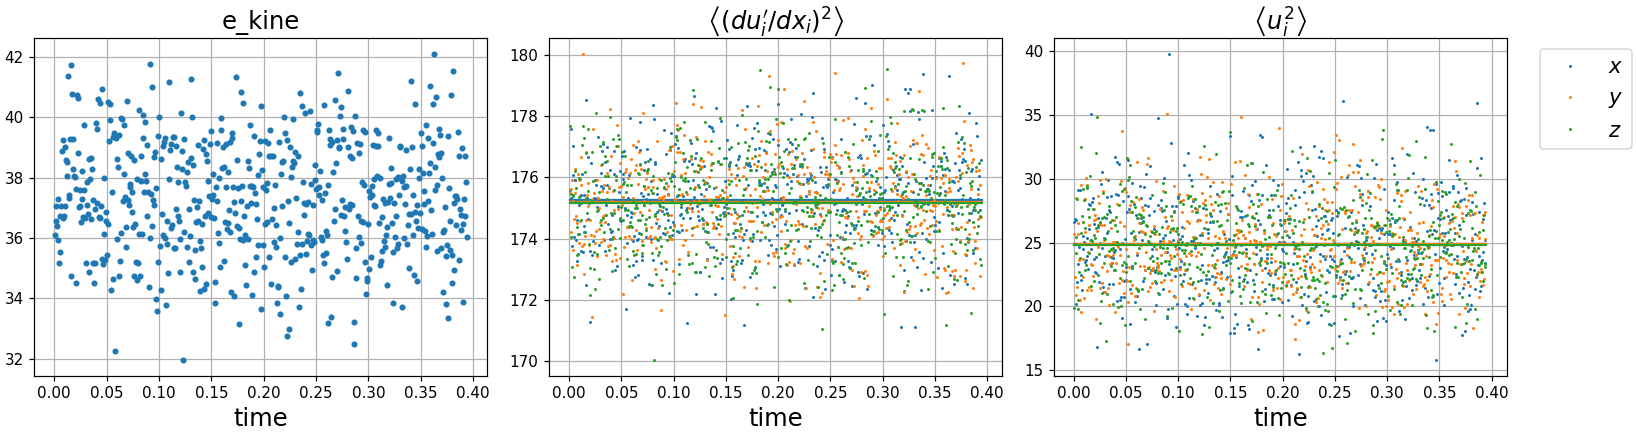

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(15,4))
t = correlations['time']
it = slice(0,-1)
param = 'e_kine'
ax[0].plot(t[it], correlations[param][it], '.')
ax[0].set(xscale='linear', yscale='linear', xlabel='time', title=param); ax[0].grid()

ax[1].plot(t[it], correlations['du/dx^2'][it], '.', label=r'$<{u^\prime}^2>$', ms=2, color=colors[0])
ax[1].plot(t, np.full_like(t,np.mean(correlations['du/dx^2'])), color=colors[0])
ax[1].plot(t[it], correlations['dv/dy^2'][it], '.', label=r'$<{v^\prime}^2>$', ms=2, color=colors[1])
ax[1].plot(t, np.full_like(t,np.mean(correlations['dv/dy^2'])), color=colors[1])
ax[1].plot(t[it], correlations['dw/dz^2'][it], '.', label=r'$<{w^\prime}^2>$', ms=2, color=colors[2])
ax[1].plot(t, np.full_like(t,np.mean(correlations['dw/dz^2'])), color=colors[2])
ax[1].set(xscale='linear', yscale='linear', xlabel='time', title=r'$\left<(d u_i^\prime/d x_i)^2 \right>$'); ax[1].grid()

ax[2].plot(t[it], correlations['u^2'][it], '.', label=r'$x$', ms=2, color=colors[0])
ax[2].plot(t, np.full_like(t,np.mean(correlations['u^2'])), color=colors[0])
ax[2].plot(t[it], correlations['v^2'][it], '.', label=r'$y$', ms=2, color=colors[1])
ax[2].plot(t, np.full_like(t,np.mean(correlations['v^2'])), color=colors[1])
ax[2].plot(t[it], correlations['w^2'][it], '.', label=r'$z$', ms=2, color=colors[2])
ax[2].plot(t, np.full_like(t,np.mean(correlations['w^2'])), color=colors[2])
ax[2].set(xscale='linear', yscale='linear', xlabel='time', title=r'$\left<u_i^2 \right>$'); ax[2].grid()
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Spectrum

In [64]:
def theor_spec_vel(k,m) :
    return 4.0*np.pi*k*k*(np.sqrt(k**2+m**2))**(-3.0-eps_scaling)

def theor_spec_scal(k) :
    return 4.0*np.pi*k*k*(k**(-3.0-2.0+eps_scaling))

<IPython.core.display.Javascript object>


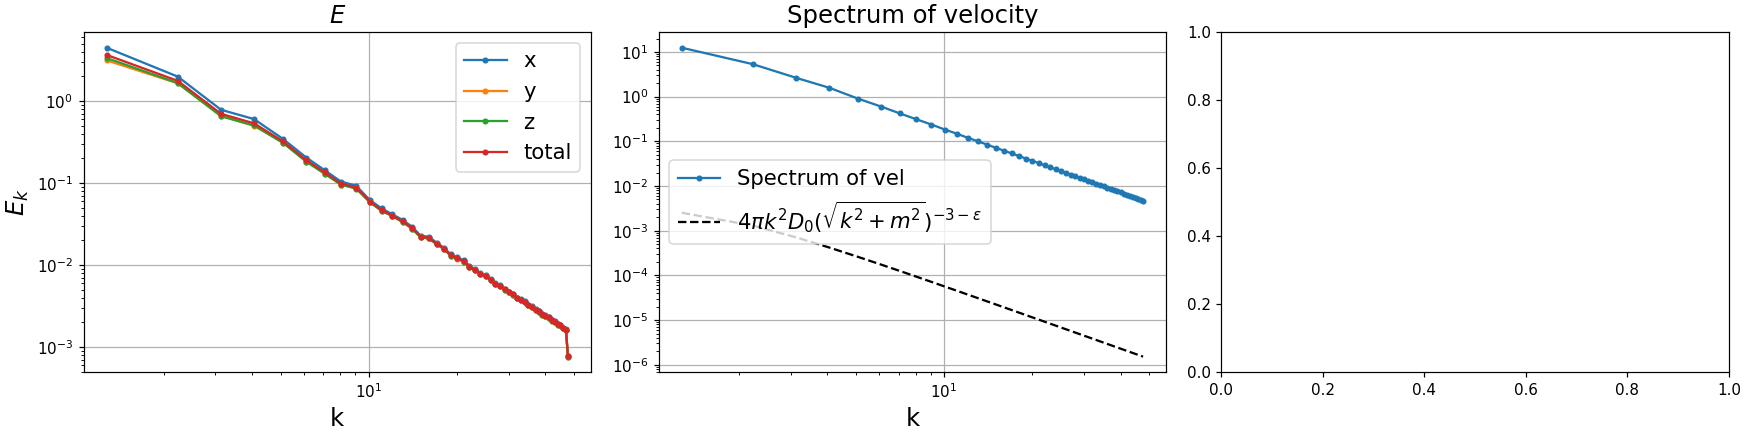

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(16,4))

ax[0].plot(k, Exx, '.-', label='x')
ax[0].plot(k, Eyy, '.-', label='y')
ax[0].plot(k, Ezz, '.-', label='z')
ax[0].plot(k, Ek/3.0, '.-', label='total')
ax[0].set(xscale='log', yscale='log', xlabel='k', ylabel=r'$E_k$', title=r'$E$'); ax[0].grid()
ax[0].legend(loc='best')

spherical_coef = 4.0*np.pi*k**2/nb_of_modes
m = 1.0

ax[1].plot(k, Ek*spherical_coef, '.-', label='Spectrum of vel')
ax[1].plot(k, D0*theor_spec_vel(k,m), 'k--', label=r'$4\pi k^2 D_0 (\sqrt{k^2+m^2})^{-3-\epsilon}$')
ax[1].set(xscale='log', yscale='log', xlabel='k', title='Spectrum of velocity'); ax[1].grid()
ax[1].legend(loc='best')

# ax[2].plot(k, Es1*spherical_coef/np.max(Es1*spherical_coef), '.-', label='Spec of scal 1')
# # ax[2].plot(k, Es2*spherical_coef/np.max(Es2*spherical_coef), '.-', label='Spec of scal 2')
# # ax[2].plot(k, Es3*spherical_coef/np.max(Es3*spherical_coef), '.-', label='Spec of scal 3')
# ax[2].plot(k, theor_spec_scal(k), 'k--', label=r'$4\pi k^2 k^{-5+\epsilon}$')
# ax[2].set(xscale='log', yscale='log', xlabel='k', title='Spectrum of scalar'); ax[2].grid()
# ax[2].legend(loc='best')

plt.show()

<IPython.core.display.Javascript object>


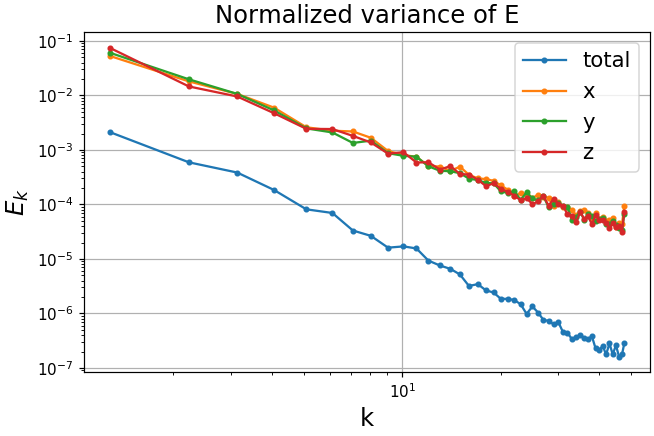

In [58]:
## Variance of the velocity spectrum
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))

ax.plot(k, Var/Ek**2, '.-', label='total')
ax.plot(k, Varxx/Exx**2, '.-', label='x')
ax.plot(k, Varyy/Eyy**2, '.-', label='y')
ax.plot(k, Varzz/Ezz**2, '.-', label='z')
#ax.plot(k, Ek/3.0, '.-', label='total')
ax.set(xscale='log', yscale='log', xlabel='k', ylabel=r'$E_k$', title='Normalized variance of E'); ax.grid()
ax.legend(loc='best')

plt.show()

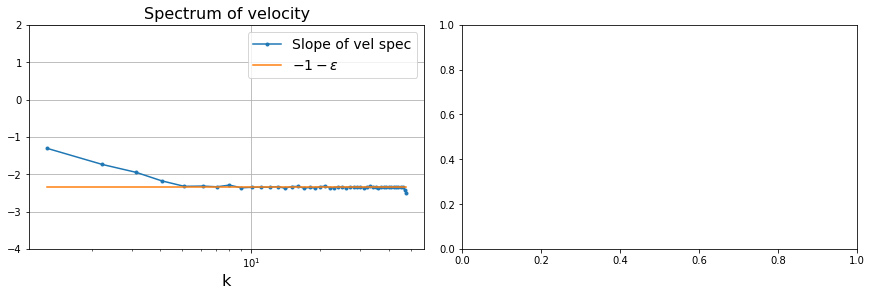

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))

spherical_coef = 4.0*np.pi*k**2/nb_of_modes
m = 1.0

ax[0].plot(k, np.gradient(np.log(Ek*spherical_coef), np.log(k)), '.-', label='Slope of vel spec')
ax[0].plot(k, np.full_like(k, -1.0-eps_scaling), label=r'$-1-\epsilon$')
ax[0].set(xscale='log', yscale='linear', xlabel='k', title='Spectrum of velocity'); ax[0].grid()
ax[0].set(ylim=[-4,2])
ax[0].legend(loc='best')

# ax[1].plot(k, np.gradient(np.log(Es1*spherical_coef), np.log(k)), '.-', label='Slope of scal 1 spec')
# # ax[1].plot(k, np.gradient(np.log(Es2*spherical_coef), np.log(k)), '.-', label='Slope of scal 2 spec')
# # ax[1].plot(k, np.gradient(np.log(Es3*spherical_coef), np.log(k)), '.-', label='Slope of scal 3 spec')
# ax[1].plot(k, np.full_like(k, (-5.0+eps_scaling+2)), label=r'$-5+\epsilon + 2$')
# ax[1].plot(k, np.full_like(k, (-5.0+2)), label=r'$-5+ 2$')
# ax[1].plot(k, np.full_like(k, (-5.0-eps_scaling+2)), label=r'$-5-\epsilon + 2$')
# ax[1].plot(k, np.full_like(k, (-5.0+eps_scaling)), label=r'$-5+\epsilon$')
# ax[1].set(xscale='log', yscale='linear', xlabel='k', title='Spectrum of scalar'); ax[1].grid()
# ax[1].set(ylim=[-10,2])
# ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
# #binning 
# lmbda=1.21
# binned_spec_length = np.int(np.floor(np.log(np.max(k))/np.log(lmbda))+1)
# binned_spec = np.zeros(binned_spec_length)
# bin_k = np.zeros(binned_spec_length)
# nb_of_point = np.zeros(binned_spec_length)
# for ik in range(len(k)-1) :
#     ibin = np.int(np.floor(np.log(k[ik])/np.log(lmbda)))
#     binned_spec[ibin] = binned_spec[ibin] + Es3[ik]*spherical_coef[ik]
#     bin_k[ibin] = bin_k[ibin] + k[ik]
#     nb_of_point[ibin] = nb_of_point[ibin] + 1
# bin_k = bin_k/nb_of_point
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))
# ax.plot(bin_k, binned_spec, '.-')
# ax.set(xscale='log', yscale='log', xlabel='k', title='Binned spec'); ax.grid()
# plt.show()

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))
# deriv1 = np.gradient(np.log(binned_spec),np.log(bin_k), edge_order=1)
# deriv2 = np.gradient(deriv1,np.log(bin_k), edge_order=1)
# deriv3 = np.gradient(np.log(np.absolute(deriv2)),np.log(bin_k), edge_order=1)

# ax.plot(bin_k, deriv3, '.-')
# ax.set(xscale='log', yscale='linear', xlabel='k', title='Exponent dissipative range'); ax.grid()
 
# plt.show()

# Structure function for scalar

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(15,4))
# ax[0].plot(r, correlations['X']['S2_scal1'], '.-', label=r'$S_{2}(r_x)$')
# ax[0].plot(r, correlations['Y']['S2_scal1'], '.-', label=r'$S_{2}(r_y)$')
# ax[0].plot(r, correlations['Z']['S2_scal1'], '.-', label=r'$S_{2}(r_z)$')
# ax[0].set(xlabel='r', ylabel=r'$S_2(r)$', title=r'$S_2(r)$ for scalar 1'); ax[0].grid()
# ax[0].legend(loc='best')

# # ax[1].plot(r, correlations['X']['S2_scal2'], '.-', label=r'$S_{2}(r_x)$')
# # ax[1].plot(r, correlations['Y']['S2_scal2'], '.-', label=r'$S_{2}(r_y)$')
# # ax[1].plot(r, correlations['Z']['S2_scal2'], '.-', label=r'$S_{2}(r_z)$')
# # ax[1].set(xlabel='r', ylabel=r'$S_2(r)$', title=r'$S_2(r)$ for scalar 2'); ax[1].grid()
# # ax[1].legend(loc='best')

# # ax[2].plot(r, correlations['X']['S2_scal3'], '.-', label=r'$S_{2}(r_x)$')
# # ax[2].plot(r, correlations['Y']['S2_scal3'], '.-', label=r'$S_{2}(r_y)$')
# # ax[2].plot(r, correlations['Z']['S2_scal3'], '.-', label=r'$S_{2}(r_z)$')
# # ax[2].set(xlabel='r', ylabel=r'$S_2(r)$', title=r'$S_2(r)$ for scalar 3'); ax[2].grid()
# # ax[2].legend(loc='best')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(15,4))
# ax[0].plot(r, correlations['X']['S2_scal1'], '.-', label=r'$S_{2}(r_x)$')
# ax[0].plot(r, correlations['Y']['S2_scal1'], '.-', label=r'$S_{2}(r_y)$')
# ax[0].plot(r, correlations['Z']['S2_scal1'], '.-', label=r'$S_{2}(r_z)$')
# ax[0].set(yscale='log', xscale='log', xlabel='r', ylabel=r'$S_2(r)$', title=r'$S_2(r)$ for scalar 1 in log-log scale'); ax[0].grid()
# ax[0].legend(loc='best')

# # ax[1].plot(r, correlations['X']['S2_scal2'], '.-', label=r'$S_{2}(r_x)$')
# # ax[1].plot(r, correlations['Y']['S2_scal2'], '.-', label=r'$S_{2}(r_y)$')
# # ax[1].plot(r, correlations['Z']['S2_scal2'], '.-', label=r'$S_{2}(r_z)$')
# # ax[1].set(yscale='log', xscale='log', xlabel='r', ylabel=r'$S_2(r)$', title=r'$S_2(r)$ for scalar 2 in log-log scale'); ax[1].grid()
# # ax[1].legend(loc='best')

# # ax[2].plot(r, correlations['X']['S2_scal3'], '.-', label=r'$S_{2}(r_x)$')
# # ax[2].plot(r, correlations['Y']['S2_scal3'], '.-', label=r'$S_{2}(r_y)$')
# # ax[2].plot(r, correlations['Z']['S2_scal3'], '.-', label=r'$S_{2}(r_z)$')
# # ax[2].set(yscale='log', xscale='log', xlabel='r', ylabel=r'$S_2(r)$', title=r'$S_2(r)$ for scalar 3 in log-log scale'); ax[2].grid()
# # ax[2].legend(loc='best')
# plt.show()

NameError: name 'r' is not defined

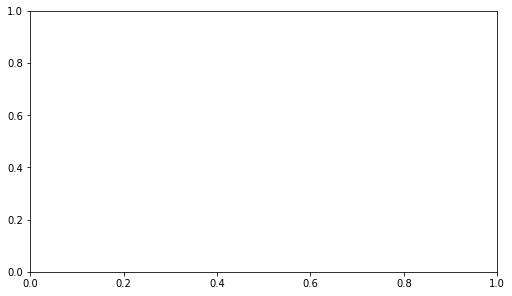

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(7,4))
compensation = r[1::]**(-(2.0-eps_scaling))
ax.plot(r[1::], correlations['X']['S2_scal1'][1::]*compensation, '.-', label=r'$S_{2}(r_x)$')
ax.plot(r[1::], correlations['Y']['S2_scal1'][1::]*compensation, '.-', label=r'$S_{2}(r_y)$')
ax.plot(r[1::], correlations['Z']['S2_scal1'][1::]*compensation, '.-', label=r'$S_{2}(r_z)$')

ax.set(xlabel='r', ylabel=r'$S_2/r^{2-\epsilon}$', yscale='linear', xscale='log', title=r'$S_2$ compensated'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(15,4))
i = slice(1,None)
ax[0].plot(r[i], np.gradient(np.log(correlations['X']['S2_scal1'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_x)$')
ax[0].plot(r[i], np.gradient(np.log(correlations['Y']['S2_scal1'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_y)$')
ax[0].plot(r[i], np.gradient(np.log(correlations['Z']['S2_scal1'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_z)$')
ax[0].set(yscale='linear', xscale='log', xlabel='r', ylabel=r'$S_2(r)$', title=r'Slope of $S_2(r)$ for scalar 1'); ax[0].grid()
ax[0].legend(loc='best')

# ax[1].plot(r[i], np.gradient(np.log(correlations['X']['S2_scal2'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_x)$')
# ax[1].plot(r[i], np.gradient(np.log(correlations['Y']['S2_scal2'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_y)$')
# ax[1].plot(r[i], np.gradient(np.log(correlations['Z']['S2_scal2'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_z)$')
# ax[1].set(yscale='linear', xscale='log', xlabel='r', ylabel=r'$S_2(r)$', title=r'$S_2(r)$ for scalar 2 slope'); ax[1].grid()
# ax[1].legend(loc='best')

# ax[2].plot(r[i], np.gradient(np.log(correlations['X']['S2_scal3'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_x)$')
# ax[2].plot(r[i], np.gradient(np.log(correlations['Y']['S2_scal3'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_y)$')
# ax[2].plot(r[i], np.gradient(np.log(correlations['Z']['S2_scal3'][i]), np.log(r[i])), '.-', label=r'$S_{2}(r_z)$')
# ax[2].set(yscale='linear', xscale='log', xlabel='r', ylabel=r'$S_2(r)$', title=r'$S_2(r)$ for scalar 3 slope'); ax[2].grid()
# ax[2].legend(loc='best')
plt.show()

# Longitudinal vel correlations

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(7,4))
ax.plot(r, correlations['X']['XX'], '.-', label=r'$U_{xx}(r_x)$')
ax.plot(r, correlations['Y']['YY'], '.-', label=r'$U_{yy}(r_y)$')
ax.plot(r, correlations['Z']['ZZ'], '.-', label=r'$U_{zz}(r_z)$')
ax.set(xlabel='r', ylabel='C(r)', title=r'$C_{||}(r)$'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,4))
ax.plot(r, -1.0*(correlations['X']['XX']-correlations['X']['XX'][0]), '.-', label=r'$U_{xx}(r_x)$')
ax.plot(r, -1.0*(correlations['Y']['YY']-correlations['Y']['YY'][0]), '.-', label=r'$U_{yy}(r_y)$')
ax.plot(r, -1.0*(correlations['Z']['ZZ']-correlations['Z']['ZZ'][0]), '.-', label=r'$U_{zz}(r_z)$')

ax.plot(r,1.2*r**(eps_scaling), 'k--', label=r'$r^{\epsilon}$')
#ax.plot(r,0.8*r**2, 'b--', label=r'$r^{1}$')
ax.set(xlabel='r', ylabel=r'$C_{||}(0)-C_{||}(r)$', yscale='log', xscale='log', title=r'$S_2(r)$ in log-log scale'); ax.grid()
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(loc='best')
# pp = PdfPages('Images/Scalar/vel_corr_eps05_N128.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
#plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,4))
compensation = (r[1::]**(-eps_scaling))
ax.plot(r[1::], -1.0*(correlations['X']['XX'][1::]-correlations['X']['XX'][0])*compensation, '.-', label=r'$U_{xx}(r_x)$')
ax.plot(r[1::], -1.0*(correlations['Y']['YY'][1::]-correlations['Y']['YY'][0])*compensation, '.-', label=r'$U_{yy}(r_y)$')
ax.plot(r[1::], -1.0*(correlations['Z']['ZZ'][1::]-correlations['Z']['ZZ'][0])*compensation, '.-', label=r'$U_{zz}(r_z)$')
ax.set(xlabel='r', ylabel=r'$C_{||}(0)-C_{||}(r)/r^\epsilon$', title=r'$S_2(r)$ compensated', yscale='linear', xscale='log'); ax.grid()
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(loc='best')
# pp = PdfPages('Images/Scalar/vel_corr_comp_eps05_N128.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
# plt.show()

# Transversal correlations

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(7,4))
ax.plot(r, correlations['X']['YY'], '.-', label=r'$U_{yy}(r_x)$')
ax.plot(r, correlations['X']['ZZ'], '.-', label=r'$U_{zz}(r_x)$')
ax.plot(r, correlations['Y']['XX'], '.-', label=r'$U_{xx}(r_y)$')
ax.plot(r, correlations['Y']['ZZ'], '.-', label=r'$U_{zz}(r_y)$')
ax.plot(r, correlations['Z']['XX'], '.-', label=r'$U_{xx}(r_z)$')
ax.plot(r, correlations['Z']['YY'], '.-', label=r'$U_{yy}(r_z)$')

ax.set(xlabel='r', ylabel='D(r)', yscale='linear', xscale='linear'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(7,4))
compensation = r**(-eps_scaling)
ax.plot(r, -1.0*(correlations['X']['YY']-correlations['X']['YY'][0])*compensation, '.-', label=r'$U_{yy}(r_x)$')
ax.plot(r, -1.0*(correlations['X']['ZZ']-correlations['X']['ZZ'][0])*compensation, '.-', label=r'$U_{zz}(r_x)$')
ax.plot(r, -1.0*(correlations['Y']['XX']-correlations['Y']['XX'][0])*compensation, '.-', label=r'$U_{xx}(r_y)$')
ax.plot(r, -1.0*(correlations['Y']['ZZ']-correlations['Y']['ZZ'][0])*compensation, '.-', label=r'$U_{zz}(r_y)$')
ax.plot(r, -1.0*(correlations['Z']['XX']-correlations['Z']['XX'][0])*compensation, '.-', label=r'$U_{xx}(r_z)$')
ax.plot(r, -1.0*(correlations['Z']['YY']-correlations['Z']['YY'][0])*compensation, '.-', label=r'$U_{yy}(r_z)$')

#ax.plot(r, 1.5*r**(eps_scaling),'k--', label=r'$r^{\epsilon}$')
#ax.plot(r, 0.7*r**2.0, 'b--', label=r'$r^{1}$')
ax.set(xlabel='r', ylabel=r'$D(r)/r^\epsilon$', yscale='log', xscale='log'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Off-diagonal correlations

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(7,4))
ax.plot(r, correlations['X']['XY'], '.-', label=r'$U_{xy}(r_x)$')
ax.plot(r, correlations['X']['XZ'], '.-', label=r'$U_{xz}(r_x)$')
ax.plot(r, correlations['X']['YZ'], '.-', label=r'$U_{yz}(r_x)$')
ax.plot(r, correlations['Y']['XY'], '.-', label=r'$U_{xy}(r_y)$')
ax.plot(r, correlations['Y']['XZ'], '.-', label=r'$U_{xz}(r_y)$')
ax.plot(r, correlations['Y']['YZ'], '.-', label=r'$U_{yz}(r_y)$')
ax.plot(r, correlations['Z']['XY'], '.-', label=r'$U_{xy}(r_z)$')
ax.plot(r, correlations['Z']['XZ'], '.-', label=r'$U_{xz}(r_z)$')

ax.plot(r, correlations['Z']['YZ'], '.-', label=r'$U_{yz}(r_z)$')

ax.set(xlabel='r', ylabel='D(r)', yscale='linear', xscale='linear'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()